In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import numpy as np
import operator

In [2]:
from Bio import SeqIO

fasta_disorder = SeqIO.parse('../MobiDB Data/Processed/alldisorder.fasta', 'fasta')

fasta_seq = SeqIO.parse('../MobiDB Data/Processed/allseq.fasta', 'fasta')

In [3]:
def make_num_array(string):
    return [int(s) for s in string]

protein_seq_dict = {}
for protein in fasta_seq:
    protein_seq_dict[protein.id.split("|")[0]] = str(protein.seq)

In [4]:
rows = []

def Merge(dict1, dict2):
    return(dict2.update(dict1))

def slice_arr(num_arr, disorder_type, _id, rows):
    
    label_arr = ndimage.label(num_arr)[0]
    slices = ndimage.find_objects(label_arr)
    amino_acid_sequence = protein_seq_dict.get(_id)
    
    for s in slices:
        d = {}
        segment = amino_acid_sequence[s[0]]
        d['len'] = len(segment)
        d['disorder_or_order'] = disorder_type
        d['id'] = _id
        d['fract'] = num_arr.count(1)/len(num_arr)
        
        aa_dict = count_amino_acids(segment)
        Merge(aa_dict, d)
        
        rows.append(d)

In [5]:
def count_amino_acids(aa_seq ):
    
    aa_codes = ['A', 'R', 'N', 'D', 'C', 'Q', 'E','G','H',
                'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 
                'Y', 'V', 'O', 'U', 'B', 'Z', 'X', 'J']
    counts = [0]*len(aa_codes)
    d = dict(zip(aa_codes, counts))
    for aa in aa_seq:
        d[aa] += 1
        
    return d

In [6]:
for protein in fasta_disorder:
    
    dis_num_arr = make_num_array(str(protein.seq))
    ord_num_arr = list(map(int, list(map(operator.not_, dis_num_arr))))

    _id = protein.id.split("|")[0]
    _description = protein.description.split("|")[-1]
    
    #disordered regions have the code 'D' and ordered regions have the code 'O'
    slice_arr(dis_num_arr, 'D', _id, rows)
    slice_arr(ord_num_arr, 'O', _id, rows)
    
    #adding entire protein to data frame along with the with the code 'P' for disorder_or_order
    d = {}
    d['len'] = len(str(protein.seq))
    d['disorder_or_order'] = 'P'
    d['id'] = _id
    d['description'] = _description
    
    #adding entire protein to the dictionary
    aa_seq = protein_seq_dict.get(_id)
    aa_dict = count_amino_acids(aa_seq)
    Merge(aa_dict, d)
    
    rows.append(d)
    
df = pd.DataFrame(rows)

In [7]:
df

,len,disorder_or_order,id,fract,A,R,N,D,C,Q,...,W,Y,V,O,U,B,Z,X,J,description
0,1,D,Q9UPN6,0.000787,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,1270,O,Q9UPN6,0.999213,62,87,61,63,6,90,...,11,16,99,0,0,0,0,0,0,NaN
2,1271,P,Q9UPN6,NaN,62,87,61,63,6,90,...,11,16,99,0,0,0,0,0,0,SR-related and CTD-associated factor 8 OS=Homo...
3,1,D,H0USY8,0.004115,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,242,O,H0USY8,0.995885,16,18,11,16,0,12,...,1,3,10,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173164,481,O,Q8WUI4,0.960084,29,39,5,14,1,29,...,2,2,20,0,0,0,0,0,0,NaN
173165,96,O,Q8WUI4,0.960084,4,9,3,3,4,6,...,1,2,3,0,0,0,0,0,0,NaN
173166,288,O,Q8WUI4,0.960084,34,11,12,17,7,11,...,6,6,26,0,0,0,0,0,0,NaN
173167,49,O,Q8WUI4,0.960084,5,2,1,3,1,1,...,1,0,6,0,0,0,0,0,0,NaN


# Length Distribution

## Length Distribution of Protein 

Text(0.5, 1.0, 'Length of Proteins')

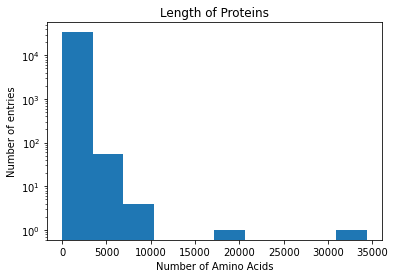

In [8]:
len_protein = df[df['disorder_or_order'] == 'P']
plt.hist(len_protein['len'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Proteins')

### Outliers

In [9]:
len_protein[len_protein['len'] > 15000]

,len,disorder_or_order,id,fract,A,R,N,D,C,Q,...,W,Y,V,O,U,B,Z,X,J,description
12712,18562,P,G4SLH0,NaN,1419,505,600,1312,177,856,...,96,231,1525,0,0,0,0,0,0,Titin homolog OS=Caenorhabditis elegans OX=623...
12740,34350,P,Q8WZ42,NaN,2084,1640,1111,1720,513,942,...,466,999,3184,0,0,0,0,0,0,Titin OS=Homo sapiens (Human) OX=9606 GN=TTN


## Length Distribution of Proteins After Removing Outliers

Text(0.5, 1.0, 'Length of Proteins')

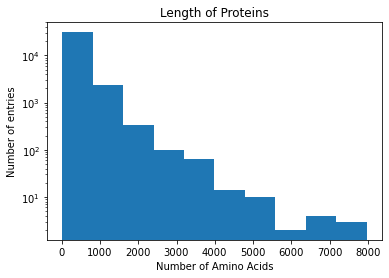

In [10]:
len_protein_outrm =  len_protein[len_protein['len'] < 15000]
plt.hist(len_protein_outrm['len'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Proteins')

## Length Distribution of Disordered Regions

Text(0.5, 1.0, 'Length of Disordered Regions')

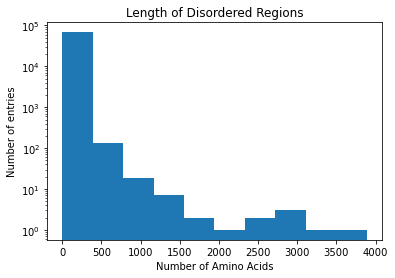

In [11]:
len_dis = df[df['disorder_or_order'] == 'D']
plt.hist(len_dis['len'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Disordered Regions')

## Length Distribution of Ordered Regions

Text(0.5, 1.0, 'Length of Ordered Regions')

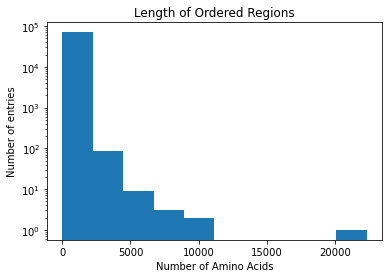

In [12]:
len_ord = df[df['disorder_or_order'] == 'O']
plt.hist(len_ord['len'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Ordered Regions')

### Outliers 

In [13]:
len_ord[len_ord['len'] > 15000]

,len,disorder_or_order,id,fract,A,R,N,D,C,Q,...,W,Y,V,O,U,B,Z,X,J,description
12739,22319,O,Q8WZ42,0.937351,1310,1184,788,1238,300,520,...,365,704,2004,0,0,0,0,0,0,NaN


In [14]:
df[df['id'] == 'Q8WZ42']

,len,disorder_or_order,id,fract,A,R,N,D,C,Q,...,W,Y,V,O,U,B,Z,X,J,description
12737,2152,D,Q8WZ42,0.062649,129,62,0,11,0,28,...,3,32,329,0,0,0,0,0,0,NaN
12738,9879,O,Q8WZ42,0.937351,645,394,323,471,213,394,...,98,263,851,0,0,0,0,0,0,NaN
12739,22319,O,Q8WZ42,0.937351,1310,1184,788,1238,300,520,...,365,704,2004,0,0,0,0,0,0,NaN
12740,34350,P,Q8WZ42,NaN,2084,1640,1111,1720,513,942,...,466,999,3184,0,0,0,0,0,0,Titin OS=Homo sapiens (Human) OX=9606 GN=TTN


# Fraction disordered distribution

Text(0.5, 1.0, 'Fraction Disordered Distribution')

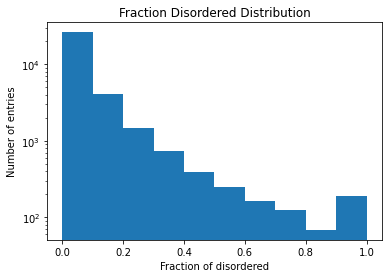

In [15]:
fract_dist = df[df['disorder_or_order'] == 'D'].drop_duplicates('id')
plt.hist(fract_dist['fract'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Fraction of disordered')
plt.title('Fraction Disordered Distribution')

# Fraction ordered distribution

Text(0.5, 1.0, 'Fraction Disordered Distribution')

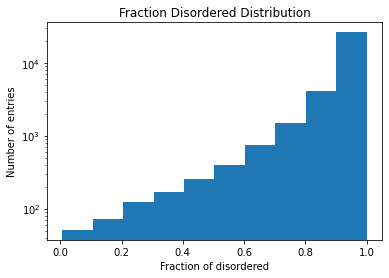

In [16]:
fract_ord = df[df['disorder_or_order'] == 'O'].drop_duplicates('id')
plt.hist(fract_ord['fract'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Fraction of disordered')
plt.title('Fraction Disordered Distribution')

# Correlation of fraction disordered with number of disordered segments

## 2D Histogram

Text(0.5, 1.0, 'Number Disordered Regions vs. Disordered Content')

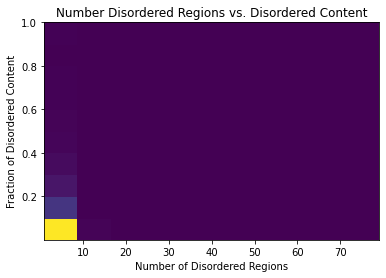

In [17]:
num_dis_seg = df[df['disorder_or_order'] == 'D'].groupby('id').size().reset_index(name='counts')
plt.hist2d(num_dis_seg['counts'],fract_dist['fract'])
plt.ylabel('Fraction of Disordered Content')
plt.xlabel('Number of Disordered Regions')
plt.title('Number Disordered Regions vs. Disordered Content')

Text(0.5, 1.0, 'Number Disordered Content vs.  Disordered Region')

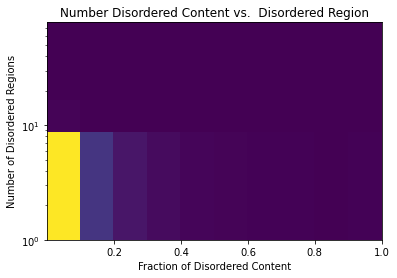

In [18]:
plt.hist2d(fract_dist['fract'],num_dis_seg['counts'])
plt.yscale('log')
plt.xlabel('Fraction of Disordered Content')
plt.ylabel('Number of Disordered Regions')
plt.title('Number Disordered Content vs.  Disordered Region')

## Scatter plot

Text(0.5, 1.0, 'Number Disordered Regions vs. Disordered Content')

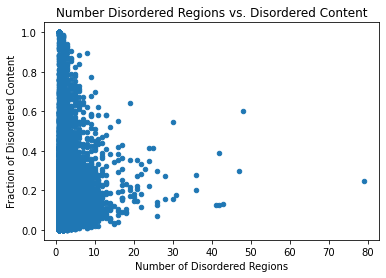

In [19]:
df_merge = pd.merge(num_dis_seg, fract_dist, on='id', how='outer')
df_merge
df_merge.plot.scatter( x = 'counts', y = 'fract')
plt.ylabel('Fraction of Disordered Content')
plt.xlabel('Number of Disordered Regions')
plt.title('Number Disordered Regions vs. Disordered Content')

### Outliers

In [20]:
df_merge[df_merge['counts'] > 50]

,id,counts,len,disorder_or_order,fract,A,R,N,D,C,...,W,Y,V,O,U,B,Z,X,J,description
9996,O94248,79,1,D,0.249523,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [21]:
df[df['id'] == 'O94248']

,len,disorder_or_order,id,fract,A,R,N,D,C,Q,...,W,Y,V,O,U,B,Z,X,J,description
22550,1,D,O94248,0.249523,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
22551,4,D,O94248,0.249523,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,NaN
22552,4,D,O94248,0.249523,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
22553,8,D,O94248,0.249523,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
22554,1,D,O94248,0.249523,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22703,23,O,O94248,0.750477,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,NaN
22704,45,O,O94248,0.750477,1,3,1,3,2,3,...,0,2,2,0,0,0,0,0,0,NaN
22705,128,O,O94248,0.750477,5,3,11,5,3,3,...,0,1,7,0,0,0,0,0,0,NaN
22706,214,O,O94248,0.750477,12,8,8,15,2,13,...,1,7,14,0,0,0,0,0,0,NaN


## Scatter plot without Outliers 

Text(0.5, 1.0, 'Number Disordered Regions vs. Disordered Content')

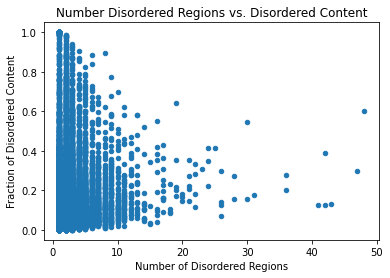

In [22]:
df_merge_outrm = df_merge[df_merge['counts'] < 50]
df_merge_outrm.plot.scatter( x = 'counts', y = 'fract')
plt.ylabel('Fraction of Disordered Content')
plt.xlabel('Number of Disordered Regions')
plt.title('Number Disordered Regions vs. Disordered Content')

## Flipping Scatter Plot 

<AxesSubplot:xlabel='fract', ylabel='counts'>

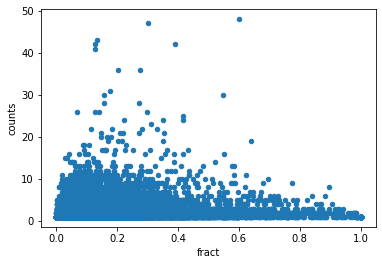

In [23]:
df_merge_outrm.plot.scatter( x = 'fract', y = 'counts')

## Correlation Coefficient

In [24]:
correlation = df_merge_outrm['counts'].corr(df_merge_outrm['fract'])
correlation

0.18345657133347204

# Correlation of average length of disordered segments with number of disordered segments

## 2D Histogram 

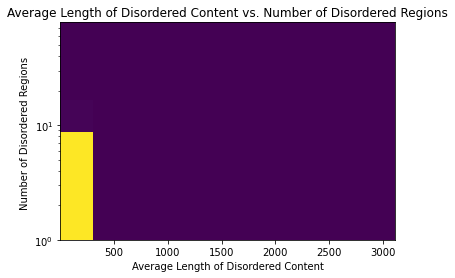

In [25]:
dis_df = df[df['disorder_or_order'] == 'D']
dis_avg_len = dis_df[['id', 'len']].groupby('id').mean().reset_index()
plt.hist2d(dis_avg_len['len'],num_dis_seg['counts'])
plt.xlabel('Average Length of Disordered Content')
plt.ylabel('Number of Disordered Regions ')
plt.title('Average Length of Disordered Content vs. Number of Disordered Regions')
plt.yscale('log')

## Scatter plot

Text(0.5, 1.0, 'Number of Disordered Regions vs. Average Length of Disordered Regions')

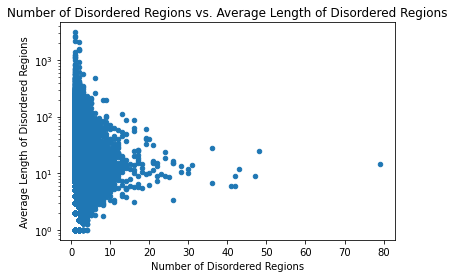

In [26]:
num_dis_avg_merge = pd.merge(num_dis_seg, dis_avg_len, on='id', how='outer')
num_dis_avg_merge.plot.scatter( x = 'counts', y = 'len')
plt.yscale('log')
plt.ylabel('Average Length of Disordered Regions')
plt.xlabel('Number of Disordered Regions')
plt.title('Number of Disordered Regions vs. Average Length of Disordered Regions')

### Flipping Scatter Plot

Text(0, 0.5, 'Number of Disordered Regions')

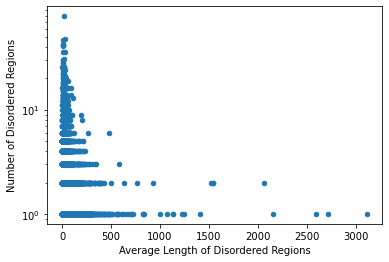

In [27]:
num_dis_avg_merge = pd.merge(num_dis_seg, dis_avg_len, on='id', how='outer')
num_dis_avg_merge.plot.scatter( x = 'len', y = 'counts')
plt.yscale('log')
plt.xlabel('Average Length of Disordered Regions')
plt.ylabel('Number of Disordered Regions')

## Scatter plot without outliers

Text(0.5, 1.0, 'Number of Disordered Regions vs. Average Length of Disordered Regions')

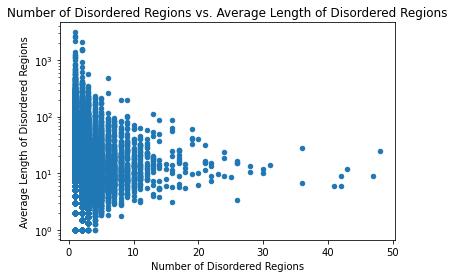

In [28]:
num_dis_avg_merge_outrm = num_dis_avg_merge[num_dis_avg_merge['counts'] < 50]
num_dis_avg_merge_outrm.plot.scatter( x = 'counts', y = 'len')
plt.yscale('log')
plt.ylabel('Average Length of Disordered Regions')
plt.xlabel('Number of Disordered Regions')
plt.title('Number of Disordered Regions vs. Average Length of Disordered Regions')

# Number disordered segments in proteins distribution

Text(0.5, 1.0, 'Number of Disordered Segments Distribution')

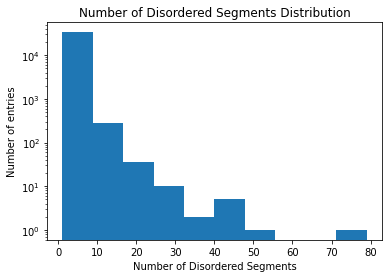

In [29]:
plt.hist(num_dis_seg['counts'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Disordered Segments')
plt.title('Number of Disordered Segments Distribution')

### Outliers

In [30]:
num_dis_seg[num_dis_seg['counts'] > 60]

,id,counts
9996,O94248,79


Text(0.5, 1.0, 'Number of Disordered Segments Distribution')

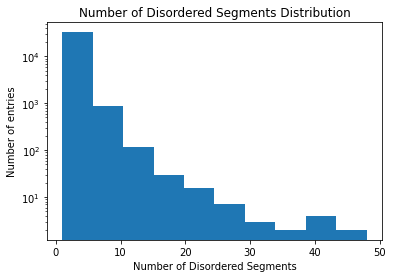

In [31]:
num_dis_seg_outrm = num_dis_seg[num_dis_seg['counts'] < 60]
plt.hist(num_dis_seg_outrm['counts'])
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Disordered Segments')
plt.title('Number of Disordered Segments Distribution')

# Amino acid distributions and enrichment 

## Disordered Segments 

In [71]:
aa_codes = ['A', 'R', 'N', 'D', 'C', 'Q', 'E','G','H',
                'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 
                'Y', 'V', 'O', 'U', 'B', 'Z', 'X', 'J']

Text(0.5, 1.0, 'Disordered Region Amino Acid Distribution')

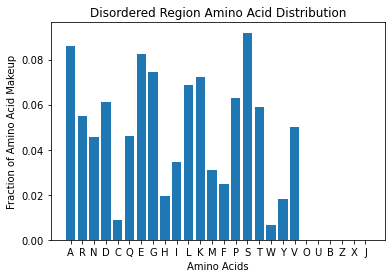

In [72]:
aa_counts_dis = df.loc[df['disorder_or_order'] == 'D', aa_codes].sum()
aa_fracs_dis = aa_counts_dis /aa_counts_dis.sum()
plt.bar(aa_codes, aa_fracs_dis)
plt.ylabel('Fraction of Amino Acid Makeup')
plt.xlabel('Amino Acids')
plt.title('Disordered Region Amino Acid Distribution')

Text(0.5, 1.0, 'Total Amino Acid Distribution')

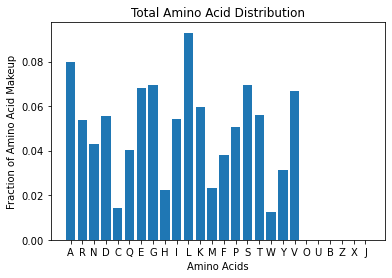

In [73]:
aa_counts = df.loc[df['disorder_or_order'] == 'P', aa_codes].sum()
aa_fracs = aa_counts /aa_counts.sum()
plt.bar(aa_codes, aa_fracs)
plt.ylabel('Fraction of Amino Acid Makeup')
plt.xlabel('Amino Acids')
plt.title('Total Amino Acid Distribution')

## Overlay Bar Chart Amino Acid Distributions over Proteins vs. Disordered Segments

In [74]:
"source: https://stackoverflow.com/questions/23293011/how-to-plot-a-superimposed-bar-chart-using-matplotlib-in-python"

def overlapped_bar(df, show=False, width=0.9, alpha=.5,
                   title='', xlabel='', ylabel='', **plot_kwargs):
    """Like a stacked bar chart except bars on top of each other with transparency"""
    xlabel = xlabel or df.index.name
    N = len(df)
    M = len(df.columns)
    indices = np.arange(N)
    colors = ['steelblue', 'firebrick', 'darksage', 'goldenrod', 'gray'] * int(M / 5. + 1)
    for i, label, color in zip(range(M), df.columns, colors):
        kwargs = plot_kwargs
        kwargs.update({'color': color, 'label': label})
        plt.bar(indices, df[label], width=width, alpha=alpha if i else 1, **kwargs)
        plt.xticks(indices + .5 * width,
                   ['{}'.format(idx) for idx in df.index.values])
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if show:
        plt.show()
    return plt.gcf()

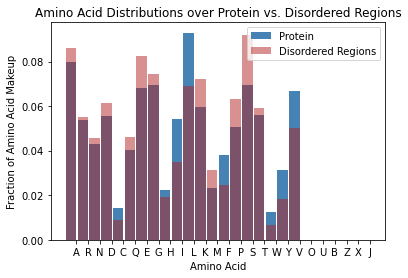

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [75]:
df_overlap_bar = pd.DataFrame(np.matrix([aa_fracs, aa_fracs_dis]).T, columns=['Protein', 'Disordered Regions'],
                  index=pd.Index(aa_codes))
overlapped_bar(df_overlap_bar, show=True, title='Amino Acid Distributions over Protein vs. Disordered Regions',
              xlabel='Amino Acid', ylabel='Fraction of Amino Acid Makeup')

Text(0.5, 1.0, 'Difference of Protein and Disordered Segments Amino Acid Distribution')

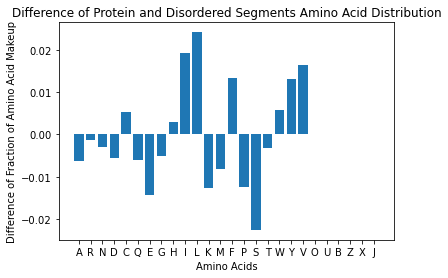

In [70]:
aa_fracs_dif = aa_fracs - aa_fracs_dis
plt.bar(aa_codes, aa_fracs_dif)
plt.ylabel('Difference of Fraction of Amino Acid Makeup')
plt.xlabel('Amino Acids')
plt.title('Difference of Protein and Disordered Segments Amino Acid Distribution')